In [2]:
import glob, os, sys; sys.path.append('../src')

from typing import Callable, Dict, List, Optional

import pandas as pd
from pathlib import Path
import re
import logging
import string 
import pandas as pd
#from keybert import KeyBERT

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

logger = logging.getLogger(__name__)
import haystack
from haystack.utils import convert_files_to_docs, fetch_archive_from_http
from haystack.nodes.file_converter import BaseConverter, DocxToTextConverter, PDFToTextConverter, TextConverter
from haystack.schema import Document
import pdfplumber

from haystack.nodes import PreProcessor
import streamlit as st

In [3]:
# Function for reading txt,pdf and docx files 

def load_document(
    file: str,
    encoding: Optional[str] = None,
    id_hash_keys: Optional[List[str]] = None,
) -> List[Document]:
    
    """
    takes docx, txt and pdf files as input and extracts text as well as the filename as metadata. Since haystack
    does not take care of all pdf files, pdfplumber is attached to the pipeline in case the pdf extraction fails
    via Haystack.

    Returns a list of type haystack.schema.Document
    """

    if file.endswith('.pdf'):
        converter = PDFToTextConverter(remove_numeric_tables=True)
    if file.endswith('.txt'):
        converter = TextConverter()
    if file.endswith('.docx'):
        converter = DocxToTextConverter()

    print(converter)
    documents = []

    logger.info("Converting {}".format(file))
    # PDFToTextConverter, TextConverter, and DocxToTextConverter return a list containing a single Document
    document = converter.convert(
                file_path=file, meta=None, encoding=encoding, id_hash_keys=id_hash_keys
            )[0]
    text = document.content
    documents.append(Document(content=text, meta={"name": file}, id_hash_keys=id_hash_keys))
    
    '''check if text is empty and apply different pdf processor. This can happen whith certain pdf types.'''
    
    return documents

In [5]:
'''basic cleaning - suitable for transformer models'''
def basic(s):
    """
    :param s: string to be processed
    :return: processed string: see comments in the source code for more info
    """
    # Text Lowercase
    s = s.lower() 
    # Remove punctuation
    translator = str.maketrans(' ', ' ', string.punctuation) 
    s = s.translate(translator)
    # Remove URLs
    s = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', s, flags=re.MULTILINE)
    s = re.sub(r"http\S+", " ", s)
    # Remove new line characters
    s = re.sub('\n', ' ', s) 
  
    # Remove distracting single quotes
    s = re.sub("\'", " ", s) 
    # Remove all remaining numbers and non alphanumeric characters
    s = re.sub(r'\d+', ' ', s) 
    s = re.sub(r'\W+', ' ', s)

    # define custom words to replace:
    #s = re.sub(r'strengthenedstakeholder', 'strengthened stakeholder', s)
    
    return s.strip()

 

def preprocessing(document):

    """
    takes in haystack document object and splits it into paragraphs and applies simple cleaning.

    Returns cleaned list of haystack document objects. One paragraph per object. Also returns pandas df and 
    list that contains all text joined together.
    """    

    preprocessor = PreProcessor(
        clean_empty_lines=True,
        clean_whitespace=True,
        clean_header_footer=True,
        split_by="word",
        split_length=120,
        split_respect_sentence_boundary=True,
        #split_overlap=5
    )
    for i in document:
        docs_processed = preprocessor.process([i])
        for item in docs_processed:
            item.content = basic(item.content)

    print("your document has been splitted to", len(docs_processed), "paragraphs")
    
    # create dataframe of text and list of all text
    df = pd.DataFrame(docs_processed)
    all_text = " ".join(df.content.to_list())
    par_list = df.content.to_list()

    return df

In [7]:
import os
from PyPDF2 import PdfReader

# Change the current working directory
os.chdir('C:\\Users\\serva\\Downloads\\NDCs')

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))


cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))


# Safe directory in a var
directory_in_str='C:\\Users\\serva\\Downloads\\NDCs'
directory = os.fsencode(directory_in_str)


Current working directory: C:\Users\serva\Downloads\NDCs
Files in 'C:\\Users\\serva\\Downloads\\NDCs': ['Australias NDC June 2022 Update.docx', 'BOTSWANA.docx', 'EU_NDC_Submission_December 2020.docx', 'Updated - First NDC - FINAL - PDF.docx']


In [23]:
#Test
""""data=pd.DataFrame(columns=["content","text","id","meta","score","embedding"])
df=preprocessing(docs)
data1=data.append(df)

print(data1)"""

data=pd.DataFrame(columns=["content","text","id","meta","score","embedding"])

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    docs=load_document(filename)
# Using the Preprocessor to create df and text 
    df = preprocessing(docs)
    data=data.append(df)


INFO - __main__ -  Converting Australias NDC June 2022 Update.docx
2022-08-16 17:49:36.842 INFO    __main__: Converting Australias NDC June 2022 Update.docx


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 381.99docs/s]
C:\Users\serva\AppData\Local\Temp\ipykernel_18444\3447353972.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(df)
INFO - __main__ -  Converting BOTSWANA.docx
2022-08-16 17:49:36.952 INFO    __main__: Converting BOTSWANA.docx


your document has been splitted to 14 paragraphs


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 853.54docs/s]
C:\Users\serva\AppData\Local\Temp\ipykernel_18444\3447353972.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(df)
INFO - __main__ -  Converting EU_NDC_Submission_December 2020.docx
2022-08-16 17:49:36.999 INFO    __main__: Converting EU_NDC_Submission_December 2020.docx


your document has been splitted to 9 paragraphs


  0%|                                                                                          | 0/1 [00:00<?, ?docs/s]WARNING - haystack.nodes.preprocessor.preprocessor -  One or more sentence found with word count higher than the split length.
2022-08-16 17:49:37.031 WARNING haystack.nodes.preprocessor.preprocessor: One or more sentence found with word count higher than the split length.
100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 171.47docs/s]
C:\Users\serva\AppData\Local\Temp\ipykernel_18444\3447353972.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(df)


your document has been splitted to 38 paragraphs

INFO - __main__ -  Converting Updated - First NDC - FINAL - PDF.docx
2022-08-16 17:49:37.068 INFO    __main__: Converting Updated - First NDC - FINAL - PDF.docx


  0%|                                                                                          | 0/1 [00:00<?, ?docs/s]WARNING - haystack.nodes.preprocessor.preprocessor -  One or more sentence found with word count higher than the split length.
2022-08-16 17:49:37.086 WARNING haystack.nodes.preprocessor.preprocessor: One or more sentence found with word count higher than the split length.
100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 226.52docs/s]

your document has been splitted to 40 paragraphs



C:\Users\serva\AppData\Local\Temp\ipykernel_18444\3447353972.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=data.append(df)


In [24]:
len(data)

101

In [25]:
data.head(5)

,content,text,id,meta,score,embedding,content_type
0,commonwealth of australia creative commons attribution international licence...,NaN,d2055926c3e3d72d804f0a85ff79b42,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 0}",None,None,text
1,the full licence terms are available from content contained herein should be...,NaN,cedb83948b28dc12f54f342b734deeeb,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 1}",None,None,text
2,no representation expressed or implied is made as to the currency accuracy r...,NaN,470a3cb556e9eb11cb75633cac46e8b2,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 2}",None,None,text
3,both targets are economywide emissions reduction commitments covering all se...,NaN,677fca625f05d36da91dad3b9fc1de07,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 3}",None,None,text
4,it reflects the australian government s resolve to urgently step up action a...,NaN,4e12db243fde45e6e1b8b99fb865bdad,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 4}",None,None,text


In [26]:
# Rename the columns 

data=data.rename(columns = {'content':'Text'})

data.head(10)

,Text,text,id,meta,score,embedding,content_type
0,commonwealth of australia creative commons attribution international licence...,NaN,d2055926c3e3d72d804f0a85ff79b42,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 0}",None,None,text
1,the full licence terms are available from content contained herein should be...,NaN,cedb83948b28dc12f54f342b734deeeb,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 1}",None,None,text
2,no representation expressed or implied is made as to the currency accuracy r...,NaN,470a3cb556e9eb11cb75633cac46e8b2,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 2}",None,None,text
3,both targets are economywide emissions reduction commitments covering all se...,NaN,677fca625f05d36da91dad3b9fc1de07,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 3}",None,None,text
4,it reflects the australian government s resolve to urgently step up action a...,NaN,4e12db243fde45e6e1b8b99fb865bdad,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 4}",None,None,text
5,the australian government is working to urgently implement these policies to...,NaN,c2ee6398537ac65e7591b85b957bdd79,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 5}",None,None,text
6,a powering the regions fund to support the development of new clean energy i...,NaN,604457c5620e049fb968306436885fa3,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 6}",None,None,text
7,australia s first national electric vehicle strategy to reduce emissions and...,NaN,6d20bd5f94f1c1306614dafac6eb4c4e,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 7}",None,None,text
8,these new measures will build on existing emissions reduction and low emissi...,NaN,29888d9e51beeface2fe54477104ba68,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 8}",None,None,text
9,the annual statement and other climate policy will be informed by australia ...,NaN,177da64dfdc21898f9fdf2972508994c,"{'name': 'Australias NDC June 2022 Update.docx', '_split_id': 9}",None,None,text


In [27]:
# Data Structures
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

In [28]:

corpus = data['Text'].tolist()
corpus[18][0:20]



'with climate variabi'

In [29]:


# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord



In [30]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = applyStemming(listOfTokens, param_stemmer)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [31]:
language = 'english'
corpus = processCorpus(corpus, language)
corpus[12][0:460]


'invest health resili ocean ecosystem includ strengthen manag nation network marin park spend addit million top exist invest protect great barrier reef establish depart climat chang energi environ water climat mitig adapt well climat biodivers crise address holist australia look forward make even stronger contribut global climat scienc share expertis experi skill across globe toward stronger adapt resili outcom tabl australia nation determin contribut tabl '

In [32]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

101 rows


C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
licenc,0.460465,0.118562,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
attribut,0.326799,0.105182,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.119917,0.0,0.0,0.0,0.0
creativ,0.301028,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
commonwealth,0.258720,0.111027,0.000000,0.0,0.0,0.0,0.0,0.231579,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
public,0.243005,0.156424,0.193147,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [33]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
licenc,0.460465,0.118562,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
attribut,0.326799,0.105182,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.119917,0.0,0.0,0.0,0.0
creativ,0.301028,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
commonwealth,0.258720,0.111027,0.000000,0.0,0.0,0.0,0.0,0.231579,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
public,0.243005,0.156424,0.193147,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [34]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [35]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\cluster\_

{2: KMeans(algorithm='full', n_clusters=2, random_state=1), 3: KMeans(algorithm='full', n_clusters=3, random_state=1), 4: KMeans(algorithm='full', n_clusters=4, random_state=1), 5: KMeans(algorithm='full', n_clusters=5, random_state=1), 6: KMeans(algorithm='full', n_clusters=6, random_state=1), 7: KMeans(algorithm='full', n_clusters=7, random_state=1), 8: KMeans(algorithm='full', random_state=1)}


C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


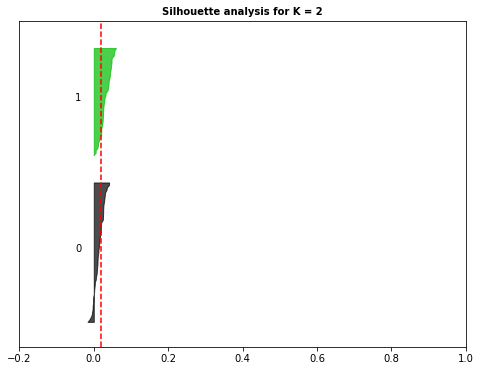

C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


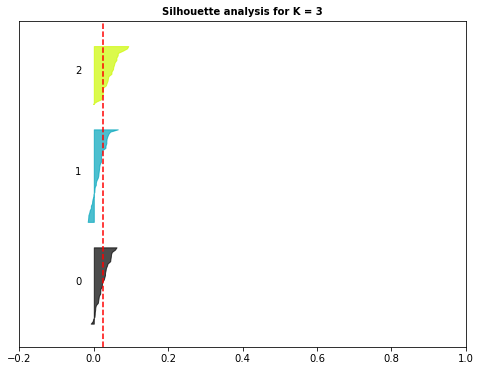

C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


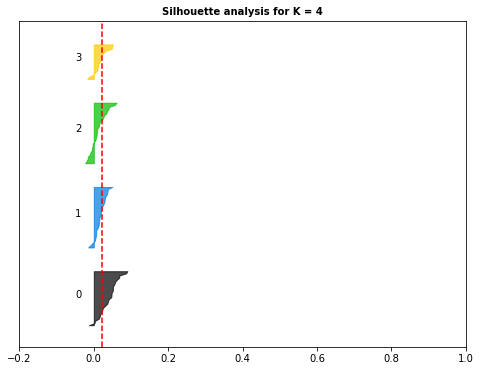

C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


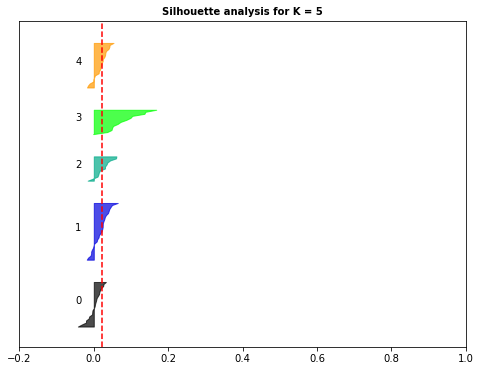

C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


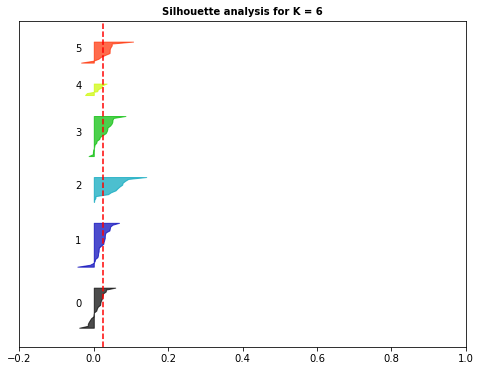

C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


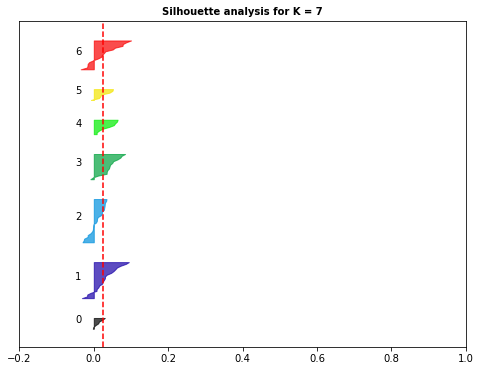

C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


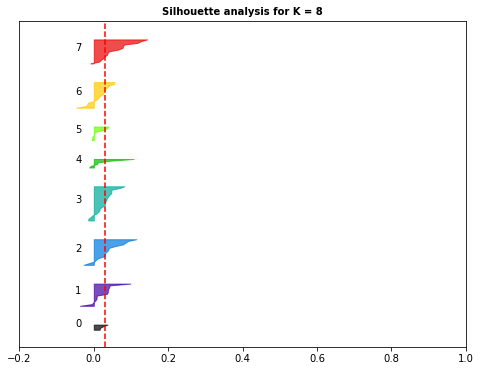

In [36]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)

print(kmeans_results)

# Plotting Silhouette Analysis
silhouette(kmeans_results, final_df, plot=True)

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets
iris = datasets.load_iris()

#we are usingh
df=pd.DataFrame(iris['data'])

print(df.head())

     0    1    2    3
0  5.1  3.5  1.4  0.2
1  4.9  3.0  1.4  0.2
2  4.7  3.2  1.3  0.2
3  4.6  3.1  1.5  0.2
4  5.0  3.6  1.4  0.2


In [38]:
best_result = 4
kmeans = kmeans_results.get(best_result)
prediction = kmeans.predict(final_df)
print(prediction)

[1 3 0 2 3 3 3 3 3 3 0 1 1 0 2 3 1 1 2 1 1 1 1 0 0 2 3 3 3 0 1 0 2 2 2 3 2
 2 3 2 0 0 0 2 2 0 2 2 3 2 0 0 2 2 2 2 2 2 2 0 0 0 1 0 0 0 2 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 2 0 2 2 0 1 1 1 1 2 3 3 3 2 2 1 0 0 0]


In [39]:
""""distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(prediction)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()"""

'"distortions = []\nK = range(1,10)\nfor k in K:\n    kmeanModel = KMeans(n_clusters=k)\n    kmeanModel.fit(prediction)\n    distortions.append(kmeanModel.inertia_)\n    \nplt.figure(figsize=(16,8))\nplt.plot(K, distortions, \'bx-\')\nplt.xlabel(\'k\')\nplt.ylabel(\'Distortion\')\nplt.title(\'The Elbow Method showing the optimal k\')\nplt.show()'

In [40]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\serva\Downloads\Anaconda\envs\py39\lib\site-packages\sklearn\utils\deprec

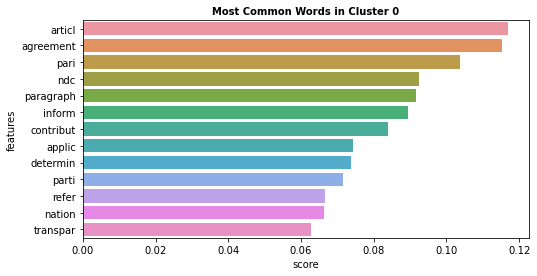

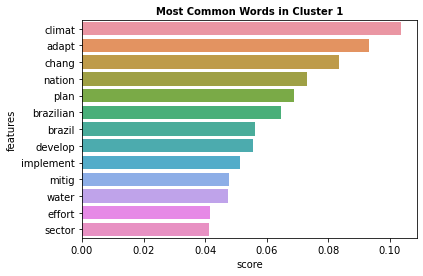

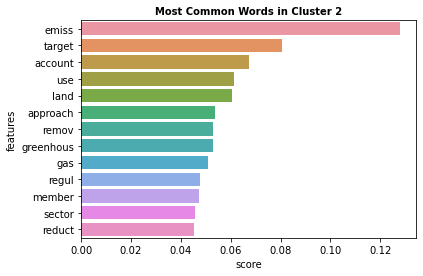

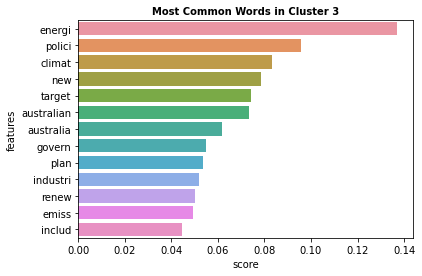

In [41]:
best_result = 4
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [45]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

In [46]:
print(centroids)

           abat           abc   aboveground   absolut       acceler  \
0  0.000000e+00  0.000000e+00  4.336809e-19  0.010752  1.734723e-18   
1 -2.168404e-19  4.336809e-19  8.673617e-19  0.005072  2.602085e-18   
2 -2.168404e-19  4.336809e-19  5.426703e-03  0.004599  4.176246e-03   
3  7.841949e-03  2.306744e-02  0.000000e+00  0.000000  2.580966e-02   

         access     accompani        accord   account       accumul  ...  \
0  2.168404e-19  9.094592e-03  2.756064e-02  0.013777 -2.168404e-19  ...   
1  4.336809e-19  1.301043e-18  1.599364e-02  0.003665  0.000000e+00  ...   
2  4.336809e-19  1.301043e-18  1.895328e-02  0.067396  0.000000e+00  ...   
3  7.598976e-03  0.000000e+00 -3.469447e-18  0.023495  7.689146e-03  ...   

          women          wood          work      workforc     world  \
0  0.000000e+00 -2.602085e-18 -2.602085e-18  0.000000e+00  0.005712   
1  5.339929e-03 -2.602085e-18  1.325985e-02 -2.168404e-19  0.004841   
2  2.168404e-19  1.375856e-02 -2.602085e-18 -2.168

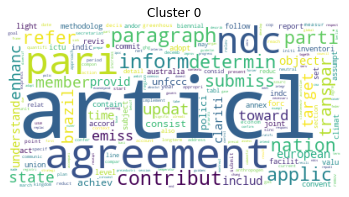

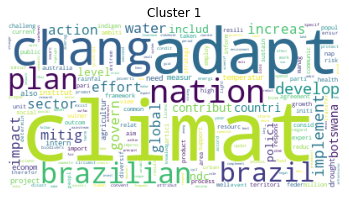

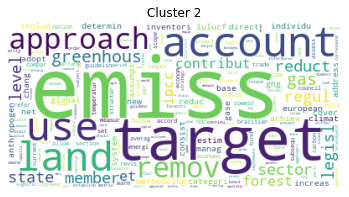

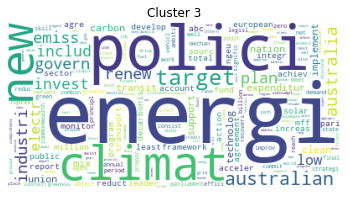

In [47]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)